# Does she really like me ? :)

This notebook demonstrates head pose and eye line (view direction) estimation from smartphone selfie video<br>
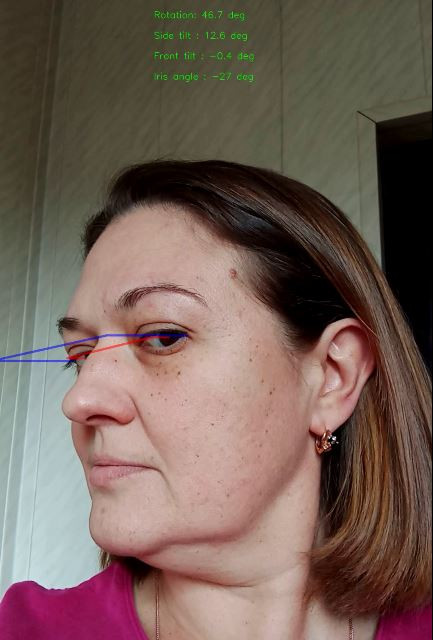
<br>
Full video is available [**here**](https://disk.yandex.ru/d/-ogzSx8JG3PdvQ) in online viewer


## The algorithm
* Face and iris landmarks are recognized by mediapipe
* The angle of head rotation is calculated by positions of the outer corners of the eyes
* The angle of head left-right tilt is calculated by the same points
* Two additional points are synthesised to calculate the angle of head front-back tilt back: the "middle eye" - the virtual point between the eyes and the "middle jaw" - the virtual point between the sides of the jaw
* A moving average is used to smooth landmarks coordinates

#### Legend
* Head pose is showed as a big blue frame
* Eye line showed as a small red frame
* All calculated angles are printed at the top

### Remarks
* The algorithm doesn't yet provide the desired accuracy in eye line determining, still working on it
* Only left-right eye line direction is implemented yet, still working on up-down direction
<br>

Video provided by [**author**](https://www.kaggle.com/paveltrusov)

In [1]:
!pip install mediapipe

     |████████████████████████████████| 32.7 MB 209 kB/s            


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import mediapipe as mp
from scipy.spatial.distance import euclidean as euc

#### Constants and utils

In [3]:
# Video file path
path = '../input/selphievideo/selfie_video.mp4'

# Moving average period
MA = 3

# Colors
green  = (0,   255, 0)
red    = (0,   0,   255)
blue   = (255, 0,   0)

# pyplot show
def show(image, H = 10, W = 10):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize = (H, W))
    plt.xticks([]), plt.yticks([])
    plt.imshow(image)
    plt.show()

#### Video frame sample

(1920, 1080, 3)


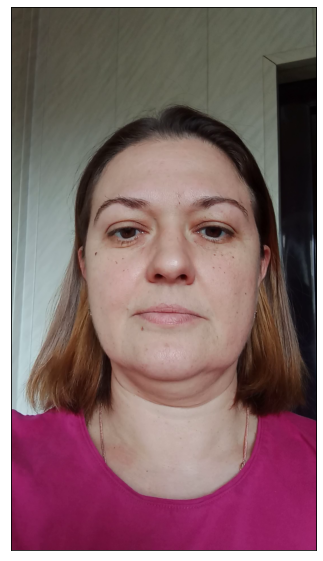

In [4]:
vs = cv2.VideoCapture(path)
template = vs.read()[1]
print(template.shape)
show(template)

#### Video strean and mediapipe initiation

In [5]:
# Mediapipe
mp_face_mesh = mp.solutions.face_mesh

#Video stream
stream       = cv2.VideoCapture(path)
fourcc       = cv2.VideoWriter_fourcc(*"MJPG")
out          = cv2.VideoWriter('head-pose-and-eye-line-estimation.avi',
                               fourcc,
                               20.0,
                               (template.shape[1],template.shape[0]))
total_frames = int(stream.get(cv2.CAP_PROP_FRAME_COUNT))

# Array to store landmarks coordinates
marks = np.zeros((478, 3, total_frames), np.float32)

In [6]:
%%time
while True:
    # Frame
    img = stream.read()[1]
    # Frame counter
    counter = int(stream.get(cv2.CAP_PROP_POS_FRAMES))
    
    if img is None:
        break
    
    original = img.copy()

    with mp_face_mesh.FaceMesh(
        static_image_mode=False,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5) as face_mesh:

        results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        if not results.multi_face_landmarks:
            print('No marks detected')
            continue

    landmarks = results.multi_face_landmarks[0].landmark
    
    # Normalized landmarks coordinates
    for i, l in enumerate(landmarks):   
        marks[i,0,counter-1] = l.x
        marks[i,1,counter-1] = l.y
        marks[i,2,counter-1] = l.z
    
    # Fill MA buffer
    if counter < MA:
        continue

    else:
        marks_abs = marks.copy()
        
        # Last points averaging
        marks_abs = marks_abs[:, :, counter-MA : counter].mean(axis = -1)
        
        # absolute coordinates
        marks_abs[:,0] = marks_abs[:,0] * img.shape[1]
        marks_abs[:,1] = marks_abs[:,1] * img.shape[0]
        marks_abs[:,2] = marks_abs[:,2] * img.shape[1]

        marks_abs = marks_abs.astype(int)

        R_eye_idx  = 33   # Outer corner
        L_eye_idx  = 263  # Outer corner
        
        R_iris_idx = 468  # Right iris center
        L_iris_idx = 473  # Left iris center
        
        Jaw_idx    = [150, 379]  # Side jaw points
        
        ## Rotation and side tilt angles calculation
        
        # Eyes coordinates
        X0, Y0, Z0 = marks_abs[R_eye_idx]
        X1, Y1, Z1 = marks_abs[L_eye_idx]

        # Side tilt angle
        L = euc((X0, Y0), (X1, Y1))
        dY = Y0 - Y1
        alpha = np.arcsin(dY / L)
        
        # Rotation angle
        L = euc((X0, Z0), (X1, Z1))
        dZ = Z0 - Z1
        beta = np.arcsin(dZ / L)
        

        ## Front tilt angle calculation
        
        # "Middle jaw" point
        JX = int(marks_abs[Jaw_idx][:,0].mean())
        JY = int(marks_abs[Jaw_idx][:,1].mean())
        JZ = int(marks_abs[Jaw_idx][:,2].mean())
        
        # "Middle eye" point
        EX = (X0 + X1) // 2
        EY = (Y0 + Y1) // 2
        EZ = (Z0 + Z1) // 2

        # Front tilt angle
        L = euc((EY, EZ), (JY, JZ))
        dZ = JZ - EZ
        gamma = np.arcsin(dZ / L)
        

        # # # Eye line
        
        # Irises coords
        R_iris_X, R_iris_Y, R_iris_Z = marks_abs[R_iris_idx]
        L_iris_X, L_iris_Y, L_iris_Z = marks_abs[L_iris_idx]
        
        # Distances between irises and eyes outer corners
        d_R = euc((R_iris_X, R_iris_Y, R_iris_Z), (X0, Y0, Z0))
        d_L = euc((L_iris_X, L_iris_Y, L_iris_Z), (X1, Y1, Z1))
        
        # Iris rotation angle
        theta = (d_L - d_R) / (d_L + d_R)
        theta = np.arcsin(theta) * 360 / 100
        
        ## Drawing
        
        # AR perspective distance to illustrate frames
        Line = img.shape[1] // 4
        
        line_params = {'thickness' : 4,
                       'lineType'  : cv2.LINE_AA}
        
        # Head pose frame
        newX0 = X0 - int(Line * np.sin(beta))
        newX1 = X1 - int(Line * np.sin(beta))
        newY0 = Y0 + int(Line * np.sin(gamma))
        newY1 = Y1 + int(Line * np.sin(gamma))
        
        cv2.line(img, (X0, Y0), (newX0, newY0), blue, **line_params)
        cv2.line(img, (X1, Y1), (newX1, newY1), blue, **line_params)
        cv2.line(img, (newX0, newY0), (newX1, newY1), blue, **line_params)
        
        # Eye line frame
        new_iris_X0 = R_iris_X - int(Line//2 * np.sin(theta + beta))
        new_iris_Y0 = R_iris_Y 
        new_iris_X1 = L_iris_X - int(Line//2 * np.sin(theta + beta))
        new_iris_Y1 = L_iris_Y
        
        cv2.line(img, (R_iris_X, R_iris_Y), (new_iris_X0, new_iris_Y0),
                 red, **line_params)
        cv2.line(img, (L_iris_X, L_iris_Y), (new_iris_X1, new_iris_Y1),
                 red, **line_params)
        cv2.line(img, (new_iris_X0, new_iris_Y0), (new_iris_X1, new_iris_Y1),
                 red, **line_params)
        
        # Add transparency
        img = cv2.addWeighted(img, 0.5, original, 0.5, 0)
        
        # Text
        text_params = {'fontFace'   : cv2.FONT_HERSHEY_SIMPLEX,
                       'fontScale'  : 0.75,
                       'color'      : green,
                       'thickness'  : 1,
                       'lineType'   : cv2.LINE_AA}
        
        cv2.putText(img,
            "Head rotation: " + str(round(np.degrees(beta), 1)) + ' deg', 
            org = (400, 100), **text_params)
        
        cv2.putText(img,
            "Head side tilt : " + str(round(np.degrees(alpha), 1)) + ' deg', 
            org = (400, 150), **text_params)
        
        cv2.putText(img,
            "Head front tilt : " + str(round(np.degrees(gamma), 1)) + ' deg', 
            org = (400, 200), **text_params)
        cv2.putText(img,
            "Eye line angle : " + str(int(np.degrees(theta))) + ' deg', 
            org = (400, 250), **text_params)

        cv2.putText(img,
            "Frame: " + str(counter), 
            org = (20, img.shape[0] // 10 * 9), **text_params)
        
        out.write(img)
    
out.release()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


CPU times: user 1min 27s, sys: 5.2 s, total: 1min 32s
Wall time: 1min 3s


#### Thank you for your attention !
If any questions please don't hestiate to ask me via **pavel.trusov 'at' hotmail.com**